
# Assignment: Forecasting Exchange Rates using Time Series Analysis (ARIMA vs Exponential Smoothing)

**Dataset:** `exchange_rate.csv` fileciteturn14file0  
**Goal:** Forecast exchange rates and compare **ARIMA** with **Exponential Smoothing (ETS)**.

This notebook follows the assignment tasks:
- **Part 1:** Data loading, exploration, preprocessing  
- **Part 2:** ARIMA (ACF/PACF → fit → diagnostics → forecast)  
- **Part 3:** ETS (fit → forecast) + evaluation (MAE, RMSE, MAPE) + comparison + conclusion


In [1]:


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [2]:
df = pd.read_csv("exchange_rate.csv")
print("Original shape:", df.shape)
df.head()


Original shape: (7588, 2)


,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [3]:
# Parse date column
df.columns = [c.strip() for c in df.columns]
date_col = df.columns[0]

df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.dropna(subset=[date_col]).sort_values(date_col)

# Set date as index
df = df.set_index(date_col)

print("After parsing dates:", df.shape)
df.head()


After parsing dates: (2998, 1)


,Ex_rate
date,
1990-01-01,0.7855
1990-01-02,0.7500
1990-01-03,0.7471
1990-01-04,0.7587
1990-01-05,0.7852



## Cell 3 — Choose a currency series

If the dataset has multiple currency columns, we'll pick the first numeric column.
You can change `target_col` to another currency column if needed.


In [4]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
print("Numeric columns found:", numeric_cols)

target_col = numeric_cols[0]
ts = df[target_col].copy()

print("Target column:", target_col)
ts.head()


Numeric columns found: ['Ex_rate']
Target column: Ex_rate


,Ex_rate
date,
1990-01-01,0.7855
1990-01-02,0.7500
1990-01-03,0.7471
1990-01-04,0.7587
1990-01-05,0.7852


# Part 1: Data Preparation and Exploration

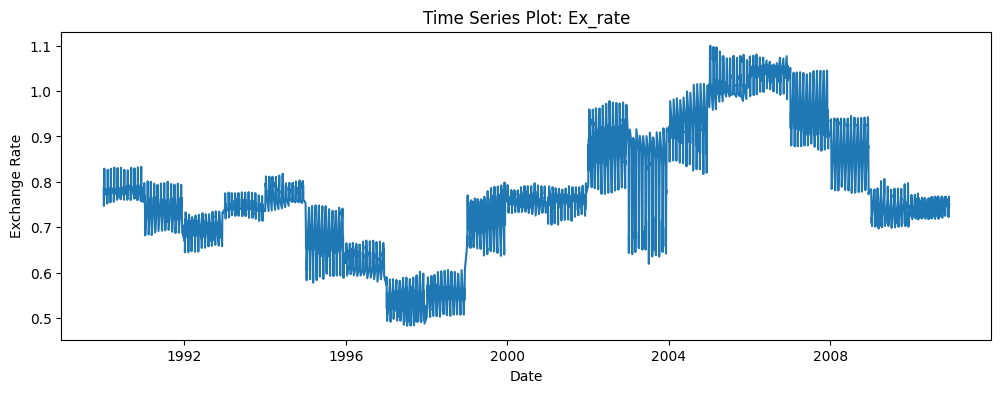

In [5]:
plt.figure(figsize=(12,4))
plt.plot(ts)
plt.title(f"Time Series Plot: {target_col}")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.show()


In [6]:
print("Missing values:", ts.isna().sum())
ts.describe()


Missing values: 0


,Ex_rate
count,2998.000000
mean,0.777235
std,0.137225
min,0.483297
25%,0.703350
50%,0.761792
75%,0.869513
max,1.099699


In [7]:
ts_clean = ts.copy()
ts_clean = ts_clean.interpolate(method="time")
ts_clean = ts_clean.ffill().bfill()

print("Missing after cleaning:", ts_clean.isna().sum())
ts_clean.head()


Missing after cleaning: 0


,Ex_rate
date,
1990-01-01,0.7855
1990-01-02,0.7500
1990-01-03,0.7471
1990-01-04,0.7587
1990-01-05,0.7852


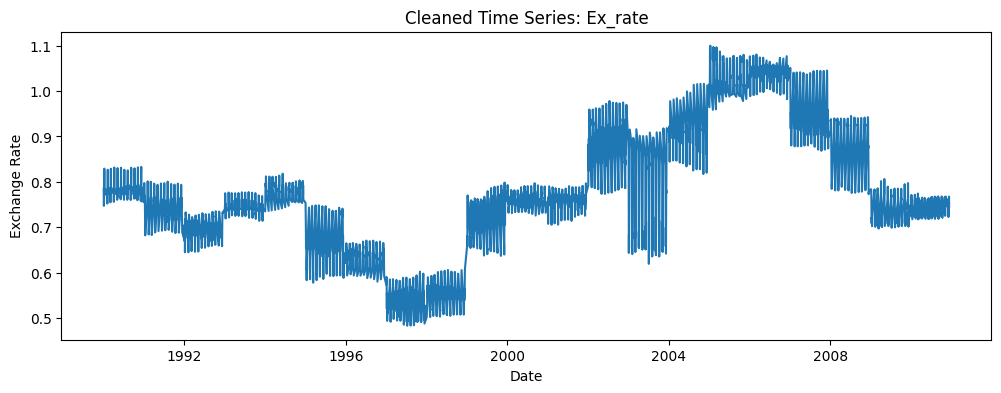

In [8]:
plt.figure(figsize=(12,4))
plt.plot(ts_clean)
plt.title(f"Cleaned Time Series: {target_col}")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.show()


In [9]:
n = len(ts_clean)
test_size = int(0.20 * n)

train = ts_clean.iloc[:-test_size]
test = ts_clean.iloc[-test_size:]

print("Train size:", len(train))
print("Test size :", len(test))
print("Train period:", train.index.min(), "to", train.index.max())
print("Test period :", test.index.min(), "to", test.index.max())


Train size: 2399
Test size : 599
Train period: 1990-01-01 00:00:00 to 2006-08-11 00:00:00
Test period : 2006-08-12 00:00:00 to 2010-12-09 00:00:00


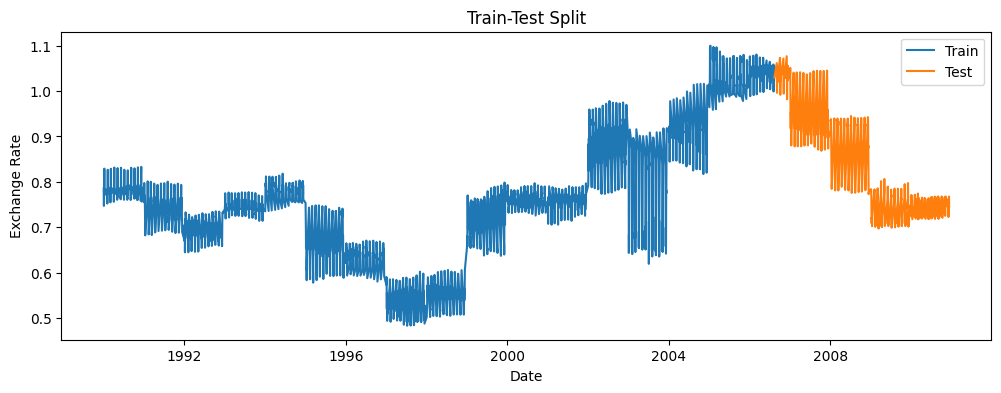

In [10]:
plt.figure(figsize=(12,4))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.title("Train-Test Split")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()


# Part 2: Model Building — ARIMA

<Figure size 1200x400 with 0 Axes>

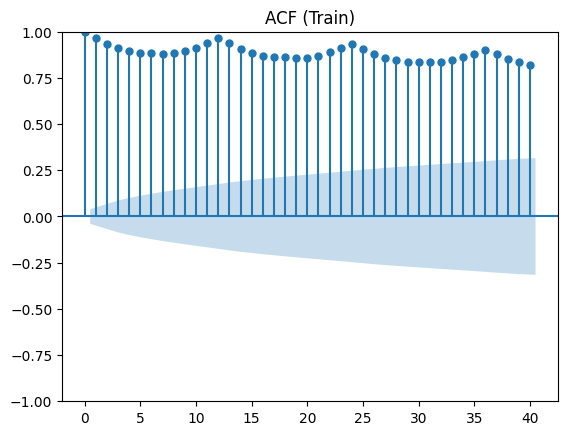

<Figure size 1200x400 with 0 Axes>

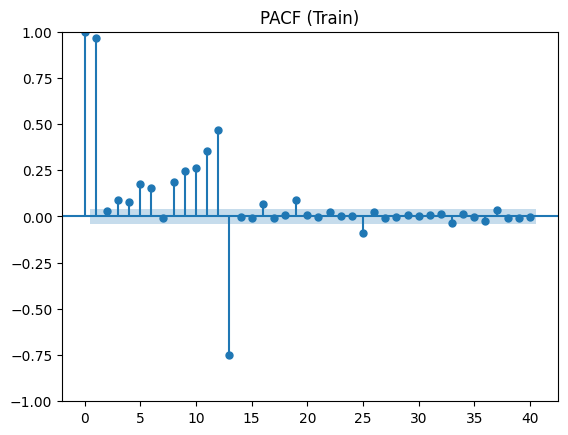

In [11]:
plt.figure(figsize=(12,4))
plot_acf(train, lags=40)
plt.title("ACF (Train)")
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(train, lags=40, method="ywm")
plt.title("PACF (Train)")
plt.show()


In [12]:
p, d, q = 1, 1, 1
print(f"Using ARIMA({p},{d},{q})")


Using ARIMA(1,1,1)


In [13]:
arima_model = ARIMA(train, order=(p, d, q))
arima_result = arima_model.fit()

print(arima_result.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 2399
Model:                 ARIMA(1, 1, 1)   Log Likelihood                4777.326
Date:                Wed, 07 Jan 2026   AIC                          -9548.652
Time:                        08:55:53   BIC                          -9531.304
Sample:                             0   HQIC                         -9542.340
                               - 2399                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6483      0.018     36.472      0.000       0.613       0.683
ma.L1         -0.9397      0.008   -115.763      0.000      -0.956      -0.924
sigma2         0.0011   1.88e-05     57.875      0.0

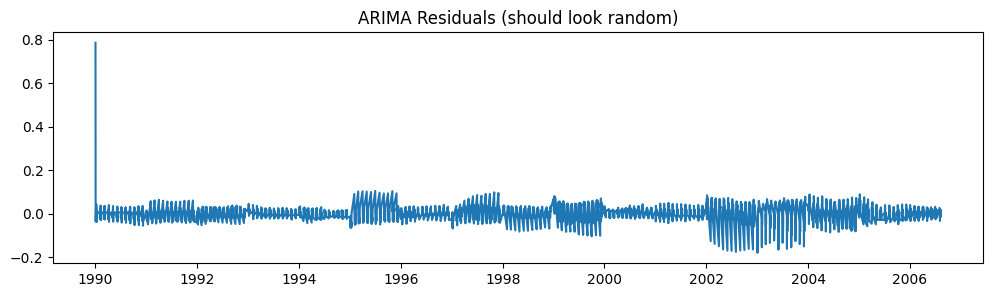

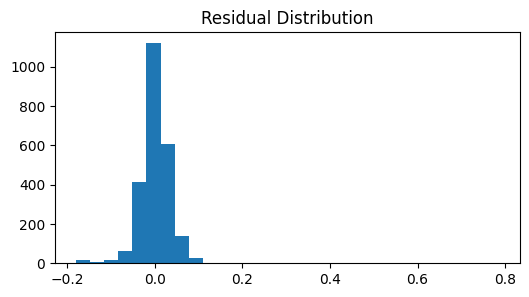

<Figure size 1200x400 with 0 Axes>

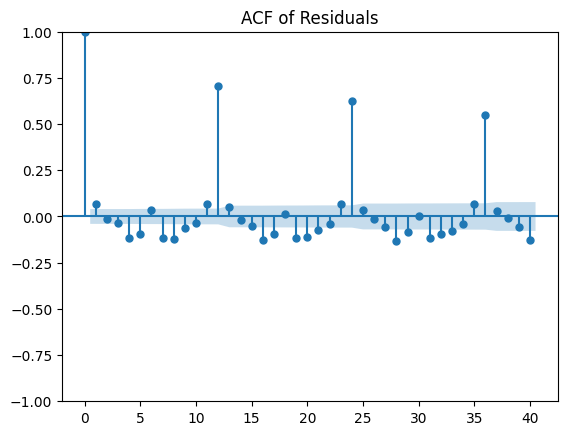

,lb_stat,lb_pvalue
10,152.663207,1.055032e-27
20,1505.165238,3.104302e-307


In [14]:
resid = arima_result.resid

plt.figure(figsize=(12,3))
plt.plot(resid)
plt.title("ARIMA Residuals (should look random)")
plt.show()

plt.figure(figsize=(6,3))
plt.hist(resid, bins=30)
plt.title("Residual Distribution")
plt.show()

plt.figure(figsize=(12,4))
plot_acf(resid, lags=40)
plt.title("ACF of Residuals")
plt.show()

ljung_box = acorr_ljungbox(resid, lags=[10, 20], return_df=True)
ljung_box


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


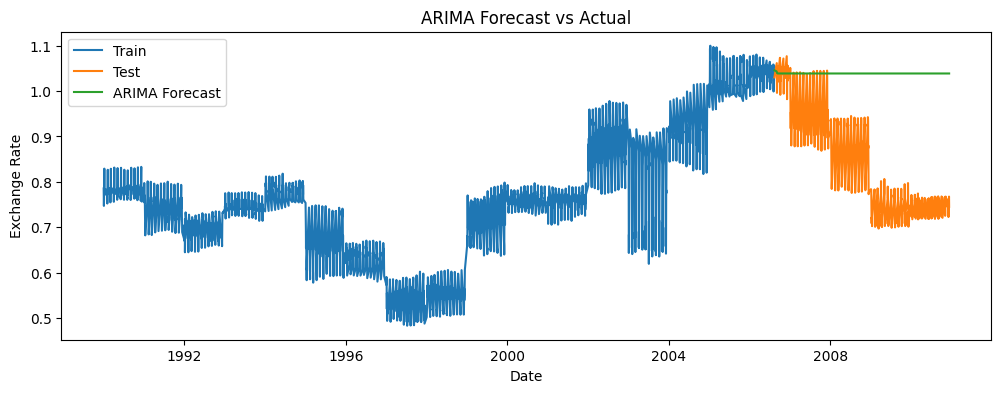

,predicted_mean
date,
2006-08-12,1.045573
2006-09-01,1.043117
2006-09-02,1.041525
2006-09-03,1.040493
2006-09-04,1.039824


In [15]:
arima_forecast = arima_result.forecast(steps=len(test))
arima_forecast.index = test.index

plt.figure(figsize=(12,4))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(arima_forecast, label="ARIMA Forecast")
plt.title("ARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()

arima_forecast.head()


# Part 2: Model Building — Exponential Smoothing (ETS)

In [16]:
ets_model = ExponentialSmoothing(train, trend="add", seasonal=None, initialization_method="estimated")
ets_result = ets_model.fit()

print("ETS params:", ets_result.params)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ETS params: {'smoothing_level': np.float64(0.9362698075265344), 'smoothing_trend': np.float64(0.0), 'smoothing_seasonal': np.float64(nan), 'damping_trend': nan, 'initial_level': np.float64(0.7831100637047811), 'initial_trend': np.float64(0.00011112902681818123), 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


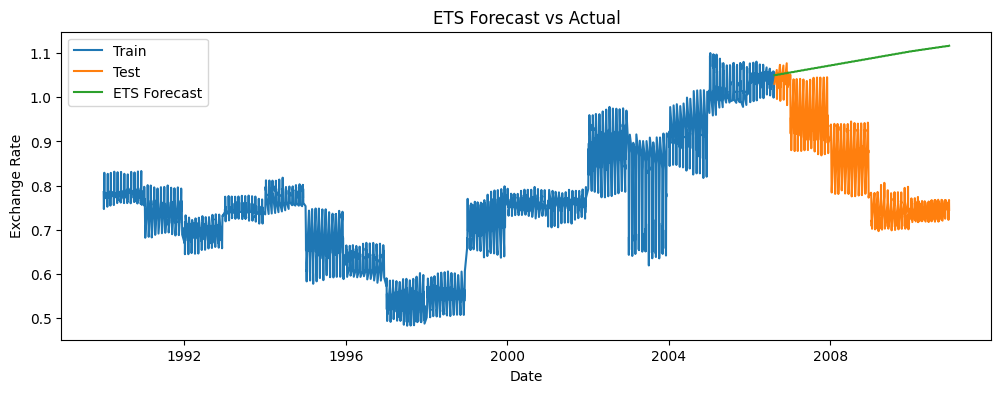

,0
date,
2006-08-12,1.049832
2006-09-01,1.049943
2006-09-02,1.050054
2006-09-03,1.050166
2006-09-04,1.050277


In [17]:
ets_forecast = ets_result.forecast(steps=len(test))
ets_forecast.index = test.index

plt.figure(figsize=(12,4))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(ets_forecast, label="ETS Forecast")
plt.title("ETS Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()

ets_forecast.head()


# Part 3: Evaluation and Comparison

In [18]:
def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

mae_arima = mean_absolute_error(test, arima_forecast)
rmse_arima = np.sqrt(mean_squared_error(test, arima_forecast))
mape_arima = mape(test, arima_forecast)

mae_ets = mean_absolute_error(test, ets_forecast)
rmse_ets = np.sqrt(mean_squared_error(test, ets_forecast))
mape_ets = mape(test, ets_forecast)

metrics = pd.DataFrame({
    "Model": ["ARIMA", "Exponential Smoothing (ETS)"],
    "MAE": [mae_arima, mae_ets],
    "RMSE": [rmse_arima, rmse_ets],
    "MAPE (%)": [mape_arima, mape_ets]
})

metrics


,Model,MAE,RMSE,MAPE (%)
0,ARIMA,0.191696,0.219491,24.571168
1,Exponential Smoothing (ETS),0.235262,0.266626,30.063340


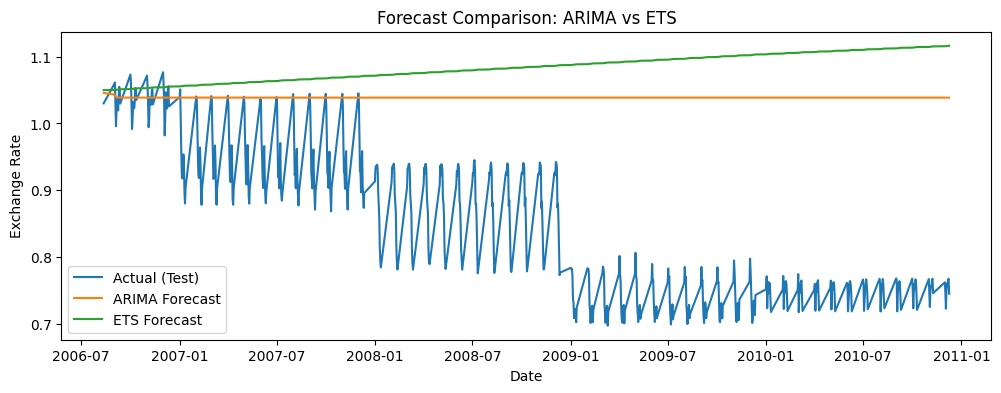

In [19]:
plt.figure(figsize=(12,4))
plt.plot(test, label="Actual (Test)")
plt.plot(arima_forecast, label="ARIMA Forecast")
plt.plot(ets_forecast, label="ETS Forecast")
plt.title("Forecast Comparison: ARIMA vs ETS")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()
